**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Introducción al Aprendizaje profundo**

*Edición 2023*

----

# Trabajo práctico entregable

Dado el dataset que busca [detectar si una oración es sarcástica o no](https://www.kaggle.com/datasets/saurabhbagchi/sarcasm-detection-through-nlp?select=Sarcasm_Headlines_Dataset.json).


## Ejercicio 1 - Preprocesamiento de los Datos

Pre-procesar los datos de texto teniendo en cuenta como baseline lo que se hizo en esta [notebook](https://colab.research.google.com/drive/1jRT2MBvOO36t3lBcV2roI1NVkzP7Cjyo?usp=sharing).
Para cargar los datos pueden guiarse de esta [notebook introductoria](https://colab.research.google.com/drive/1ZxvMQhja1fZIfbcF7u1G1LN3MfpWlBSs?usp=sharing). Tengan cuenta evaluar cuál 
es la longitud máxima de sus sentencias o qué les conviene agregar/sacar para procesar el dataset
de sarcasmo.

----

### Imports y lectura del archivo

In [2]:
import re
import json
import contractions

import nltk.corpus
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from gensim.models import KeyedVectors

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

#### Lectura del archivo

In [3]:
with open(file='./data/Sarcasm_Headlines_Dataset.json', mode='r') as file:
    data = [json.loads(line) for line in file]

#### Conversión a dataset

In [4]:
df = pd.DataFrame(data)
df.shape

(26709, 3)

In [5]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


### Análisis del dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


En este dataset observamos que no hay datos faltantes y además, todos son de tipo `object` (cadena de caracteres), excepto la variable objetivo `is_sarcastic`.

In [7]:
df.is_sarcastic.value_counts()

is_sarcastic
0    14985
1    11724
Name: count, dtype: int64

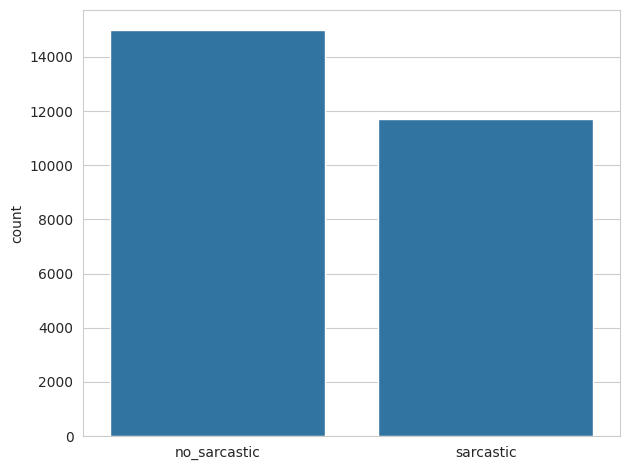

In [8]:
sns.barplot(x = np.array(['no_sarcastic','sarcastic']), 
            y = df.is_sarcastic.value_counts(),)
plt.tight_layout()

En el caso de la variable objetivo observamos que no está exactamente balanceada como en los datos del laboratorio 1, pero las cantidades son cercanas, por lo que se espera que las predicciones futuras sean de buena calidad, a diferencia de lo que sucede cuando la variable objetivo está desbalanceada, afectando el modelo de clasificación y predicción.


### Preprocesamiento

El preprocesamiento de texto es un primer paso fundamental donde se limpian los datos del texto preparándolos para lo que necesita como entrada el modelo.

#### Limpieza del texto

En este primer paso, se eliminan signos puntuación, espacios adicionales y números, luego se transforman oraciones en palabras individuales, eliminamos palabras comunes (conocidas como *stop words*) aplicamos *stemming* y *lemmatazing*. Finalmente, se obtiene las frases limpias, con palabras base listas para le próximo paso de preprocesamiento.

In [9]:
def normalize(string: str):
    """
    Converts string to lower case
    :param string: string to convert
    :return: lowercase string
    """
    return string.lower()

In [10]:
def unicode(string: str):
    """
    Eliminates punctuation, URL, and @ noise.
    :param string: string to fix
    :return: unicode string
    """
    return re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", string)

In [11]:
def del_stopwords(txt: str):
    """
    Deletes stopwords from text parameter
    :param txt: string to clean
    :return: string without stopwords
    """
    nltk.download('stopwords')
    stop = stopwords.words('english')
    return " ".join([word for word in txt.split() if word not in stop])

In [12]:
def stemming(string: str):
    """
    Groups words by their root stem
    Eg: recognize that ‘jumping’ ‘jumps’ and ‘jumped’ are all rooted to the same verb (jump)
    :param string: string to group
    :return: root converted string
    """
    stemmer = PorterStemmer()
    return stemmer.stem(word=string)

In [13]:
def pos_tagger(tag: str):
    """
    Converts POS tag to wordnet tag
    :param tag: POS tag
    :return: wordnet tag
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [14]:
def lemmatazing(txt: str):
    """
    Groups words based on root definition, and differentiates between present, past, and indefinite
    :param txt: text to lemmatize
    :return: root converted text
    """
    nltk.download('punkt')
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(txt))
    wordnet_tagged = map(lambda x: (x[0], pos_tagger(x[1])), nltk_tagged)
    lemmatized_sentence = []

    lemmatizer = WordNetLemmatizer()
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [15]:
def rm_contraction(txt: str):
    """
    Converts english contractions into it full form
    Eg: I'd -> I would
    :param txt: text to be converted
    :return: text without contractions
    """
    return contractions.fix(txt)

In [16]:
def clean_data_pipeline(dataframe: pd.DataFrame, columns: list):
    """
    Applies cleaning function to columns list of dataset
    :param dataframe: dataset to clean
    :param columns: columns to clean
    :return: cleaned dataset
    """
    aux = dataframe.copy()
    for column in columns:
        aux[column] = aux[column].apply(lambda f: normalize(f))
        aux[column] = aux[column].apply(lambda f: rm_contraction(f))
        aux[column] = aux[column].apply(lambda f: unicode(f))
        aux[column] = aux[column].apply(lambda f: del_stopwords(f))
        aux[column] = aux[column].apply(lambda f: lemmatazing(f))
    return aux

In [ ]:
clean_df = clean_data_pipeline(dataframe=df, columns=['headline'])

In [18]:
clean_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sue secret black co...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,roseanne revival catch thorny political mood w...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom start fear son web series closest thing gr...,1
3,https://politics.theonion.com/boehner-just-wan...,boehner want wife listen come alternative debt...,1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,jk rowling wish snape happy birthday magical way,0


### Vectorización

Una vez aplicado el pipeline de limpieza, resta vectorizar nuestros *headlines* para poder alimentar la red neuronal. Para este proceso utilizaremos el *embedding* pre-entrenado de *genesim*, **GoogleNews**.

In [21]:
google_news_vectors = KeyedVectors.load_word2vec_format('./embeddings/GoogleNews-vectors-negative300.bin', binary=True, limit=100000)

In [22]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [google_news_vectors[word] for word in words if word in google_news_vectors]
    if len(words_vecs) == 0:
        return np.zeros(300)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

In [23]:
 # Vectorización de los datos
clean_df.headline = clean_df.headline.apply(str) 
vec_data = np.array([vectorize(frase) for frase in clean_df.headline], dtype=np.float64)
vec_df = pd.DataFrame(data=vec_data)

In [24]:
vec_df.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.063707,0.048075,-0.035156,0.015344,-0.040704,0.029650,-0.108602,0.064033,0.079563,0.067071,...,0.093753,0.098985,-0.086890,0.072653,0.014648,-0.033034,0.081028,-0.063841,0.092285,0.013021
1,0.110565,0.088832,-0.036540,0.136963,-0.152344,-0.055520,-0.029580,0.003139,0.119420,0.089905,...,-0.103620,-0.045201,-0.051130,-0.059675,0.010145,0.024798,-0.093523,-0.024693,0.083793,0.102295
2,0.045600,-0.048794,0.060248,0.087233,-0.013570,0.068970,0.032766,-0.136597,0.160970,0.018907,...,-0.096569,0.052219,-0.179538,-0.142578,-0.029181,-0.056970,-0.084283,-0.084378,0.003689,0.014065
3,0.040670,-0.038706,0.055664,0.105265,-0.152262,0.120453,0.107564,-0.055745,0.054810,0.019618,...,-0.166016,0.091024,-0.085571,-0.017415,-0.080399,0.046712,0.049357,-0.097941,0.040263,0.005035
4,0.069037,0.069434,0.017949,0.150391,0.018481,-0.097095,0.144531,-0.128174,0.133057,0.035742,...,0.006201,0.057874,-0.129321,-0.053760,0.007910,-0.016357,-0.066657,0.001245,-0.018164,-0.040430


#### Guardado de datasets

Con el objetivo de utilizar los datos en análisis próximos, se almacenará en archivo `.csv`.

In [19]:
# Creación de carpeta contenedora
import os

container_dir = './datasets'
if not os.path.exists(container_dir):
    os.mkdir(container_dir)

In [28]:
# Guardado de dataset base
df.to_csv(os.path.join(container_dir, 'base_data.csv'), index=None)

# Guardado de dataset limpio
clean_df.to_csv(os.path.join(container_dir, 'clean_data.csv'), index=None)

# Guardado de dataset vectorizado
vec_df.to_csv(os.path.join(container_dir, 'vec_data.zip'), compression='zip', index=None)